In [5]:
from __future__ import print_function

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time

import vip_hci as vip
plots = vip.var.pp_subplots

%load_ext autoreload
%autoreload 2

%run ../util.py

plt.rcParams['text.latex.preamble']=[r"""
\usepackage{lmodern}
\usepackage{bm}"""]

params = {
    'font.family' : 'serif',
    'font.size': 8,
    'axes.labelsize': 8,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    
    'axes.linewidth': 0.5,

    'text.usetex': True,
    'figure.figsize': [3.45, 3],

    'image.cmap': 'inferno',
}
plt.rcParams.update(params) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Matrix Completion Example

In this notebook, we show how to use the library for matrix completion-based PSF estimation in this repository.

## Loading the Data

The models in this repository use VIP's `HCIDataset` to manage ADI datasets.  They encapsulate together the ADI cube, its parallactic angles, and a reference PSF.

As an example, the code below loads a cube and angle list from `"../data/bpic_naco.fits"`, and the associated reference PSF from `"../data/bpic_naco_psf.fits"`, and constructs an `HCIDataset`.

In [ ]:
dataset = vip.HCIDataset(
    cube=vip.fits.open_fits("../data/bpic_naco", n=0),  # First element in FITS file
    angles=vip.fits.open_fits("../data/bpic_naco", n=1),  # Second element in FITS file
    psf=vip.fits.open_fits("../data/bpic_naco_psf")
)

The reference PSF is normalized, such that the total flux over a FWHM-sized aperture is equal to 1:

In [ ]:
dataset.normalize_psf(verbose=False, size=psf_size)

The datasets used in the paper can be loaded (and their PSF normalized) with a single line:

In [13]:
from thesis import datasets

bpic_naco = datasets.loader('bpic_naco')
eri51 = datasets.loader('sphere_k1_51eri_2016')

Fits HDU-0 data successfully loaded. Data shape: (612, 300, 300)
Fits HDU-1 data successfully loaded. Data shape: (612,)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)
Cube array shape: (612, 300, 300)
Angles array shape: (612,)
PSF array shape: (39, 39)
Normalized PSF array shape: (21, 21)
The attribute `psfn` contains the normalized PSF
`fwhm` attribute set to
4.800978626597029
--------------------------------------------------------------------------------
Starting time: 2019-04-01 15:39:01
--------------------------------------------------------------------------------
`subi_size` is odd (while frame size is even)
Setting `subi_size` to 6 pixels
2d Gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04
shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03
Running time:  0:00:07.588798
--------------------------------------------------------------------------------
Fits HDU-0 data

To reduce computation time, the frames of each dataset are cropped to 100-by-100 pixels:

In [14]:
bpic_naco.crop_frames(100)
eri51.crop_frames(100)

New shape: (612, 100, 100)
New shape: (256, 100, 100)


## Trajectory Mask

A model PSF is constructed for a given trajectory in an ADI dataset.  We specify a trajectory by giving an `(radius, angle)` tuple, corresponding to the location of the trajectory in the first frame in radial coordinates (`radius` is expressed in pixels and `angle` in degrees).

For this example, we chose the location of the known companion in `bpic_naco`:

In [31]:
radius, angle = 16.26, 45.0

The following creates a mask of this trajectory for the dataset `bpic_naco`.  The disk size $\rho_\mathrm{ds}$ is set to 1.0.

In [32]:
mask = trajectory_mask(bpic_naco, radius, angle, 1.0)

This is what the mask looks like:

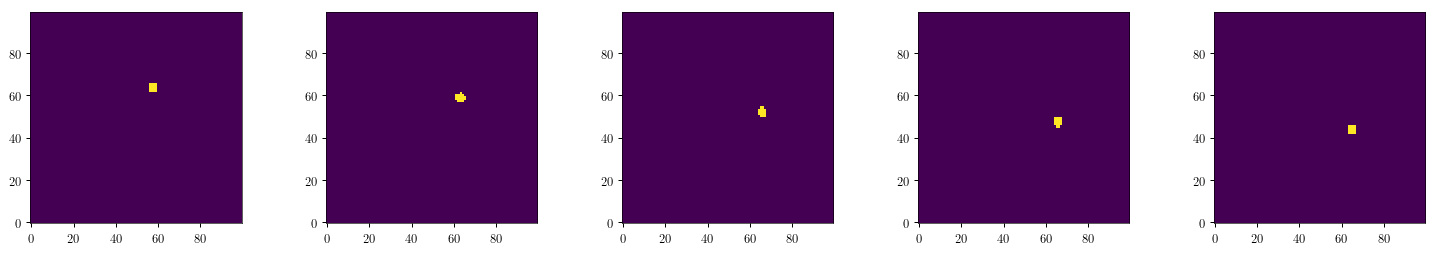

In [33]:
plots(mask[::150], colorb=False)

## Matrix Completion

We now show how to use a matrix completion model to fill the mask in the ADI cube.  We do it with the matrix factorization model used in the paper:

In [34]:
from thesis.grmf import GRMF

model = GRMF(rank=17)

The following fits the model to the dataset, and performs completion for the given mask:

In [35]:
model.fit(bpic_naco)
model_psf = model.complete(bpic_naco, mask)

The method `fit` learns features that do not require the mask, so as to reduce computation time when making sucessive calls to `complete` for different trajectories.  In the current case, `fit` does not do anything, but is still required before calling `complete`.

The result is a low-rank model of the ADI cube, built without the masked trajectory:

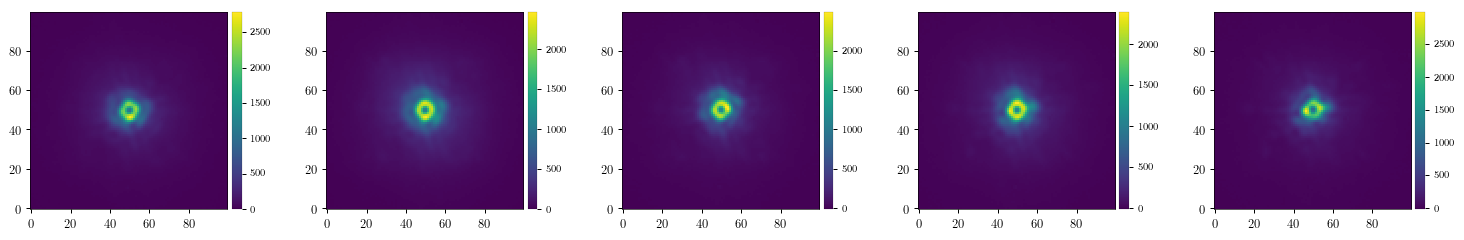

In [36]:
plots(model_psf[::150])

The residual cube is shown below:

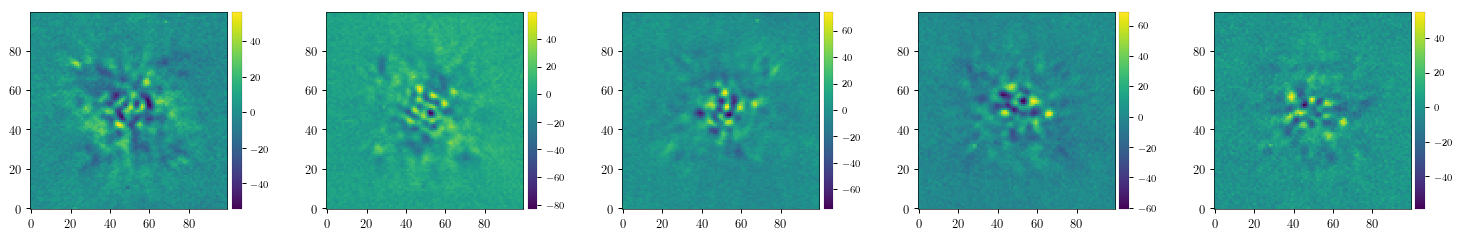

In [37]:
plots((bpic_naco.cube - model_psf)[::150])

## Maximum Likelihood Flux Estimation and Log Likelihood Ratio

Finally, we estimate the flux of the postulated companion along the trajectory, and compute the log likelihood ratio for detection.

In [38]:
flux, llr = flux_loglr_path(bpic_naco.cube - model_psf,
                            bpic_naco.psfn,
                            bpic_naco.angles,
                            radius, angle,
                            mask)

In [46]:
print("Trajectory starting at ({:.2f}, {:.2f})".format(radius, angle))
print("- Flux: {:.2f}".format(flux))
print("- Log likelihood ratio: {:.2f}".format(llr))

Trajectory starting at (16.26, 180.00)
- Flux: 485.31
- Log likelihood ratio: 10537.16


## Full Process

To summarize, here's the whole process over a different trajectory where there is no known companion:

In [41]:
radius2, angle2 = 16.26, 180.0

mask2 = trajectory_mask(bpic_naco, radius2, angle2, 1.0)

# Not necessary to re-define and re-fit the model
# model = GRMF(rank=17)
# model.fit(bpic_naco)
model_psf2 = model.complete(bpic_naco, mask2)

flux2, llr2 = flux_loglr_path(bpic_naco.cube - model_psf2,
                              bpic_naco.psfn,
                              bpic_naco.angles,
                              radius2, angle2,
                              mask2)

In [47]:
print("Trajectory starting at ({:.2f}, {:.2f})".format(radius2, angle2))
print("- Flux: {:.2f}".format(flux2))
print("- Log likelihood ratio: {:.2f}".format(llr2))

Trajectory starting at (16.26, 180.00)
- Flux: 24.19
- Log likelihood ratio: 67.45


Note that the likelihood ratio is much smaller for this trajectory than for the one that contained a companion.